In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# 【問題1】2次元畳み込み層の作成

# 【問題2】2次元畳み込み後の出力サイズ

In [3]:
sample_X = np.arange(1, 26).reshape(5, 5)
sample_W = np.arange(1, 5).reshape(2, 2)
display(sample_X)
display(sample_W)

array([[ 1,  2,  3,  4,  5],
       [ 6,  7,  8,  9, 10],
       [11, 12, 13, 14, 15],
       [16, 17, 18, 19, 20],
       [21, 22, 23, 24, 25]])

array([[1, 2],
       [3, 4]])

In [4]:
col = np.zeros([2, 2, 4, 4])
for y in range(2):
    y_max = y + 4
    for x in range(2):
        x_max = x + 4
        col[y, x, :, :] = sample_X[y:y_max, x:x_max]
display(col)
col_X = col.transpose(2, 3, 0, 1).reshape(-1, 2*2)
display(col_X)
col_W = sample_W.reshape(2*2, -1)
display(col_W)
sample_output = np.dot(col_X, col_W)
display(sample_output)
sample_output.reshape(4, 4)

array([[[[ 1.,  2.,  3.,  4.],
         [ 6.,  7.,  8.,  9.],
         [11., 12., 13., 14.],
         [16., 17., 18., 19.]],

        [[ 2.,  3.,  4.,  5.],
         [ 7.,  8.,  9., 10.],
         [12., 13., 14., 15.],
         [17., 18., 19., 20.]]],


       [[[ 6.,  7.,  8.,  9.],
         [11., 12., 13., 14.],
         [16., 17., 18., 19.],
         [21., 22., 23., 24.]],

        [[ 7.,  8.,  9., 10.],
         [12., 13., 14., 15.],
         [17., 18., 19., 20.],
         [22., 23., 24., 25.]]]])

array([[ 1.,  2.,  6.,  7.],
       [ 2.,  3.,  7.,  8.],
       [ 3.,  4.,  8.,  9.],
       [ 4.,  5.,  9., 10.],
       [ 6.,  7., 11., 12.],
       [ 7.,  8., 12., 13.],
       [ 8.,  9., 13., 14.],
       [ 9., 10., 14., 15.],
       [11., 12., 16., 17.],
       [12., 13., 17., 18.],
       [13., 14., 18., 19.],
       [14., 15., 19., 20.],
       [16., 17., 21., 22.],
       [17., 18., 22., 23.],
       [18., 19., 23., 24.],
       [19., 20., 24., 25.]])

array([[1],
       [2],
       [3],
       [4]])

array([[ 51.],
       [ 61.],
       [ 71.],
       [ 81.],
       [101.],
       [111.],
       [121.],
       [131.],
       [151.],
       [161.],
       [171.],
       [181.],
       [201.],
       [211.],
       [221.],
       [231.]])

array([[ 51.,  61.,  71.,  81.],
       [101., 111., 121., 131.],
       [151., 161., 171., 181.],
       [201., 211., 221., 231.]])

# 【問題3】最大プーリング層の作成

In [5]:
class MaxPool2D:
    def __init__(self, pool_h, pool_w, stride=1, pad=0):
        self.pool_h = pool_h
        self.pool_w = pool_w
        self.stride = stride
        self.pad = pad
    
    def forward(self, X):
        self.in_n = X.shape[0]
        self.in_c = X.shape[1]
        self.in_h = X.shape[2]
        self.in_w = X.shape[3]
        self.out_h = (self.in_h + 2*self.pad - self.pool_h)//self.stride + 1
        self.out_w = (self.in_w + 2*self.pad - self.pool_w)//self.stride + 1
        # [N, C, in_h + 2*pad, in_w + 2*pad]
        img = np.pad(X, [(0, 0),(0, 0), (self.pad, self.pad), (self.pad, self.pad)], 'constant')
        # [N, C, pool_h, pool_w, out_h, out_w]
        col = np.zeros([self.in_n, self.in_c, self.pool_h, self.pool_w, self.out_h, self.out_w])
        for y in range(self.pool_h):
            y_max = y + self.stride*self.out_h
            for x in range(self.pool_w):
                x_max = x + self.stride*self.out_w
                col[:, :, y, x, :, :] = img[:, :, y:y_max:self.stride, x:x_max:self.stride]
        # [N, C, pool_h, pool_w, out_h, out_w] → [N, C, out_h, out_w, pool_h, pool_w] → [N*C*out_h*out_w, pool_h*pool_w]
        col_X = col.transpose(0, 1, 4, 5, 2, 3).reshape(self.in_n*self.in_c*self.out_h*self.out_w, -1)
        # [N*C*out_h*out_w]
        out = np.max(col_X, axis=1)
        # [N, C, out_h, out_w]
        out = out.reshape(self.in_n, self.in_c, self.out_h, self.out_w)
        # [N*C*out_h*out_w]
        self.arg_max = np.argmax(col_X, axis=1)
        
        return out
    
    def backward(self, dout):
        pool_size = self.pool_h*self.pool_w
        # [N * C * out_h * out_w, pool_h, pool_w]
        dcol_X = np.zeros([dout.size, pool_size])
        # [N * C * out_h * out_w, pool_h, pool_w]
        dcol_X[np.arange(self.arg_max.size), self.arg_max.flatten()] = dout.flatten()
        # [N * C * out_h * out_w, pool_h, pool_w] → [N * out_h * out_w, C * pool_h * pool_w] → [N, C, pool_h, pool_w, out_h, out_w]
        dcol = dcol_X.reshape(self.in_n, self.in_c, self.out_h, self.out_w, self.pool_h, self.pool_w).transpose(0, 1, 4, 5, 2, 3)
        # [N, C, in_h + 2*pad + self.stride - 1, in_w + 2*pad + self.stride - 1]
        img = np.zeros([self.in_n, self.in_c, self.in_h + 2*self.pad + self.stride - 1, self.in_w + 2*self.pad + self.stride - 1])
        for y in range(self.pool_h):
            y_max = y + self.stride*self.out_h
            for x in range(self.pool_w):
                x_max = x + self.stride*self.out_w
                img[:, :, y:y_max:self.stride, x:x_max:self.stride] += dcol[:, :, y, x, :, :]
        # パディングとはみ出た分を取り除く
        dX = img[:, :, self.pad: self.in_h + self.pad, self.pad: self.in_w + self.pad]
        
        return dX

In [41]:
sample_dout = np.arange(1, 33).reshape(2, 1, 4, 4)
display(sample_dout)
sample_arg_max = np.random.choice([0, 1, 2, 3], 32)
display(sample_arg_max)

array([[[[ 1,  2,  3,  4],
         [ 5,  6,  7,  8],
         [ 9, 10, 11, 12],
         [13, 14, 15, 16]]],


       [[[17, 18, 19, 20],
         [21, 22, 23, 24],
         [25, 26, 27, 28],
         [29, 30, 31, 32]]]])

array([3, 1, 1, 3, 3, 1, 2, 3, 0, 3, 1, 0, 3, 2, 0, 1, 1, 3, 2, 1, 2, 1,
       3, 3, 0, 1, 2, 2, 1, 3, 1, 0])

In [42]:
sample_pool_size = 2*2
sample_dcol_X = np.zeros([sample_dout.size, sample_pool_size])
sample_dcol_X[range(sample_arg_max.size), sample_arg_max.flatten()] = sample_dout.flatten()
sample_dcol_X

array([[ 0.,  0.,  0.,  1.],
       [ 0.,  2.,  0.,  0.],
       [ 0.,  3.,  0.,  0.],
       [ 0.,  0.,  0.,  4.],
       [ 0.,  0.,  0.,  5.],
       [ 0.,  6.,  0.,  0.],
       [ 0.,  0.,  7.,  0.],
       [ 0.,  0.,  0.,  8.],
       [ 9.,  0.,  0.,  0.],
       [ 0.,  0.,  0., 10.],
       [ 0., 11.,  0.,  0.],
       [12.,  0.,  0.,  0.],
       [ 0.,  0.,  0., 13.],
       [ 0.,  0., 14.,  0.],
       [15.,  0.,  0.,  0.],
       [ 0., 16.,  0.,  0.],
       [ 0., 17.,  0.,  0.],
       [ 0.,  0.,  0., 18.],
       [ 0.,  0., 19.,  0.],
       [ 0., 20.,  0.,  0.],
       [ 0.,  0., 21.,  0.],
       [ 0., 22.,  0.,  0.],
       [ 0.,  0.,  0., 23.],
       [ 0.,  0.,  0., 24.],
       [25.,  0.,  0.,  0.],
       [ 0., 26.,  0.,  0.],
       [ 0.,  0., 27.,  0.],
       [ 0.,  0., 28.,  0.],
       [ 0., 29.,  0.,  0.],
       [ 0.,  0.,  0., 30.],
       [ 0., 31.,  0.,  0.],
       [32.,  0.,  0.,  0.]])

# 【問題4】（アドバンス課題）平均プーリングの作成

In [6]:
class AveragePool2D:
    def __init__(self, pool_h, pool_w, stride=1, pad=0):
        self.pool_h = pool_h
        self.pool_w = pool_w
        self.stride = stride
        self.pad = pad
        
    def forward(self, X):
        self.in_n = X.shape[0]
        self.in_c = X.shape[1]
        self.in_h = X.shape[2]
        self.in_w = X.shape[3]
        self.out_h = (self.in_h + 2*self.pad - self.pool_h)//self.stride + 1
        self.out_w = (self.in_w + 2*self.pad - self.pool_w)//self.stride + 1
        # [N, C, in_h + 2*pad, in_w + 2*pad]
        img = np.pad(X, [(0, 0),(0, 0), (self.pad, self.pad), (self.pad, self.pad)], 'constant')
        # [N, C, pool_h, pool_w, out_h, out_w]
        col = np.zeros([self.in_n, self.in_c, self.pool_h, self.pool_w, self.out_h, self.out_w])
        for y in range(self.pool_h):
            y_max = y + self.stride*self.out_h
            for x in range(self.pool_w):
                x_max = x + self.stride*self.out_w
                col[:, :, y, x, :, :] = img[:, :, y:y_max:self.stride, x:x_max:self.stride]
        # [N, C, pool_h, pool_w, out_h, out_w] → [N, C, out_h, out_w, pool_h, pool_w] → [N*C*out_h*out_w, pool_h*pool_w]
        col_X = col.transpose(0, 1, 4, 5, 2, 3).reshape(self.in_n*self.in_c*self.out_h*self.out_w, -1)
        # [N*C*out_h*out_w]
        out = np.mean(col_X, axis=1)
        # [N, C, out_h, out_w]
        out = out.reshape(self.in_n, self.in_c, self.out_h, self.out_w)
        
        return out
    
    def backward(self, dout):
        pool_size = self.pool_h*self.pool_w
        # [N * C * out_h * out_w, pool_h, pool_w]
        dcol_X = np.zeros([dout.size, pool_size])
        # [N * C * out_h * out_w, pool_h, pool_w]
        dcol_X += pool_size*dout.flatten().reshape(-1, 1)
        # [N * C * out_h * out_w, pool_h, pool_w] → [N * out_h * out_w, C * pool_h * pool_w] → [N, C, pool_h, pool_w, out_h, out_w]
        dcol = dcol_X.reshape(self.in_n, self.in_c, self.out_h, self.out_w, self.pool_h, self.pool_w).transpose(0, 1, 4, 5, 2, 3)
        # [N, C, in_h + 2*pad + self.stride - 1, in_w + 2*pad + self.stride - 1]
        img = np.zeros([self.in_n, self.in_c, self.in_h + 2*self.pad + self.stride - 1, self.in_w + 2*self.pad + self.stride - 1])
        for y in range(self.pool_h):
            y_max = y + self.stride*self.out_h
            for x in range(self.pool_w):
                x_max = x + self.stride*self.out_w
                img[:, :, y:y_max:self.stride, x:x_max:self.stride] += dcol[:, :, y, x, :, :]
        # パディングとはみ出た分を取り除く
        dX = img[:, :, self.pad: self.in_h + self.pad, self.pad: self.in_w + self.pad]
        
        return dX

In [7]:
c = np.ones(6).reshape(2, 3)
4*c.flatten().reshape(-1,1)

array([[4.],
       [4.],
       [4.],
       [4.],
       [4.],
       [4.]])

In [8]:
c + np.arange(2).reshape(-1, 1)

array([[1., 1., 1.],
       [2., 2., 2.]])

# 【問題5】平滑化

In [9]:
class Flatten:
    def forward(self, X):
        self.X = X
        N = self.X.shape[0]
        out = self.X.reshape(N, -1)
        
        return out
    
    def backward(self, dout):
        dZ = dout.reshape(self.X.shape)
        
        return dZ

# 【問題6】学習と推定

In [10]:
class XavierInitializer:
    def __init__(self, input_nodes):
        self.sigma = 1/np.sqrt(input_nodes)
        
    def init_weight(self, W_shape):
        W = self.sigma*np.random.randn(*W_shape)
        
        return W
    
    def init_bias(self, output_nodes):
        B = self.sigma*np.random.randn(output_nodes)
        
        return B

In [11]:
class HeInitializer:
    def __init__(self, input_nodes):
        self.sigma = np.sqrt(2/input_nodes)
        
    def init_weight(self, W_shape):
        W = self.sigma*np.random.randn(*W_shape)
        
        return W
    
    def init_bias(self, output_nodes):
        B = self.sigma*np.random.randn(output_nodes)
        
        return B

In [12]:
class AdaGrad:
    def __init__(self, lr=0.01):
        self.lr = lr
        self.h_W = 0
        self.h_B = 0
        
    def update(self, layer):
        self.h_W += layer.dW**2
        self.h_B += layer.dB**2
        layer.W -= self.lr*layer.dW/np.sqrt(self.h_W + 1e-7)
        layer.B -= self.lr*layer.dB/np.sqrt(self.h_B + 1e-7)
        
        return layer

In [13]:
class Relu:
    def __init__(self):
        self.mask = None
        
    def forward(self, A):
        self.mask = (A <=0)
        Z = A.copy()
        Z[self.mask] = 0
        
        return Z
    
    def backward(self, dZ):
        dZ[self.mask] = 0
        dA = dZ
        
        return dA

In [14]:
class SoftmaxWithLoss:
    def __init__(self):
        pass
    
    def forward(self, A):
        A -= np.max(A, axis=-1, keepdims=True)
        self.softmax = np.exp(A)/np.sum(np.exp(A), axis=-1, keepdims=True)
        
        return self.softmax
    
    def backward(self, y):
        loss = -np.sum(y*np.log(self.softmax + 1e-7))/y.shape[0]
        dA = self.softmax - y
        
        return loss, dA

In [15]:
class FC:
    """
    ノード数n_nodes1からn_nodes2への全結合層
    Parameters
    ----------
    n_nodes1 : int
      前の層のノード数
    n_nodes2 : int
      後の層のノード数
    initializer : 初期化方法のインスタンス
    optimizer : 最適化手法のインスタンス
    """
    def __init__(self, n_nodes1, n_nodes2, initializer, optimizer):
        self.optimizer = optimizer()
        self.W = initializer(n_nodes1).init_weight([n_nodes1, n_nodes2])
        self.B = initializer(n_nodes1).init_bias(n_nodes2)
        
    def forward(self, X):
        """
        フォワード
        Parameters
        ----------
        X : 次の形のndarray, shape (batch_size, n_nodes1)
            入力
        Returns
        ----------
        A : 次の形のndarray, shape (batch_size, n_nodes2)
            出力
        """        
        self.X = X
        A = np.dot(X, self.W) + self.B
        
        return A
    
    def backward(self, dA):
        """
        バックワード
        Parameters
        ----------
        dA : 次の形のndarray, shape (batch_size, n_nodes2)
            後ろから流れてきた勾配
        Returns
        ----------
        dZ : 次の形のndarray, shape (batch_size, n_nodes1)
            前に流す勾配
        """
        self.dB = np.sum(dA, axis=0)
        self.dW = np.dot(self.X.T, dA)
        dZ = np.dot(dA, self.W.T)
        
        # 更新
        self = self.optimizer.update(self)
        
        return dZ

In [16]:
class GetMiniBatch:
    """
    ミニバッチを取得するイテレータ

    Parameters
    ----------
    X : 次の形のndarray, shape (n_samples, n_features)
      訓練用データ
    y : 次の形のndarray, shape (n_samples, 1)
      正解値
    batch_size : int
      バッチサイズ
    seed : int
      NumPyの乱数のシード
    """
    def __init__(self, X, y, batch_size = 20, seed=0):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self._X = X[shuffle_index]
        self._y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)

    def __len__(self):
        return self._stop

    def __getitem__(self,item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        return self._X[p0:p1], self._y[p0:p1]        

    def __iter__(self):
        self._counter = 0
        return self

    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self._X[p0:p1], self._y[p0:p1]

In [17]:
from keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()

Using TensorFlow backend.


In [18]:
X_train = X_train.reshape(-1, 1, 28, 28)
X_test = X_test.reshape(-1, 1, 28, 28)

In [19]:
X_train = X_train.astype(np.float)
X_test = X_test.astype(np.float)
X_train /= 255
X_test /= 255
print(X_train.max()) # 1.0
print(X_train.min()) # 0.0

1.0
0.0


In [20]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
y_train_one_hot = enc.fit_transform(y_train[:, np.newaxis])
y_test_one_hot = enc.transform(y_test[:, np.newaxis])
print(y_train.shape) # (60000,)
print(y_train_one_hot.shape) # (60000, 10)
print(y_train_one_hot.dtype) # float64

(60000,)
(60000, 10)
float64


In [21]:
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train_one_hot, test_size=0.2)
print(X_tr.shape) # (48000, 1, 28, 28)
print(X_val.shape) # (12000, 1, 28, 28)

(48000, 1, 28, 28)
(12000, 1, 28, 28)


In [22]:
class cNN:
    def __init__(self, epoch=5, verbose=True):
        self.epoch = epoch
        self.verbose = verbose
        self.layers = {}
        self.layers['Conv2d1'] = Conv2d(HeInitializer, AdaGrad, [1, 28, 28], [3, 1, 4, 4], stride=2, pad=2)
        self.layers['Activation1'] = Relu()
        self.layers['MaxPool2D1'] = MaxPool2D(2, 2, stride=1, pad=0)
        self.layers['Flatten1'] = Flatten()
        self.layers['Affine1'] =  FC(588, 10, XavierInitializer, AdaGrad)
        self.last_layer = SoftmaxWithLoss()

    def fit(self, X, y, X_val=None, y_val=None):
        self.loss_list = []
        self.loss_epoch_list = []
        self.loss_val_epoch_list = []
        for i in range(self.epoch):
            get_mini_batch = GetMiniBatch(X, y, batch_size=20, seed=i)
            loss_tmp_list = []
            for X_batch, y_batch in get_mini_batch:
                for layer in self.layers.values():
                    X_batch = layer.forward(X_batch)
                softmax = self.last_layer.forward(X_batch)
                loss, dA = self.last_layer.backward(y_batch)
                self.loss_list.append(loss)
                loss_tmp_list.append(loss)
                layers = list(self.layers.values())
                layers.reverse()
                for layer in layers:
                    dA = layer.backward(dA)
                    
            epoch_mean_loss = np.mean(loss_tmp_list)
            self.loss_epoch_list.append(epoch_mean_loss)
            if self.verbose:
                print(epoch_mean_loss)
            if X_val is not None and y_val is not None:
                X_val_copy = X_val.copy()
                for layer in self.layers.values():
                    X_val_copy = layer.forward(X_val_copy)
                softmax_val = self.last_layer.forward(X_val_copy)
                loss_val = -np.sum(y_val*np.log(softmax_val + 1e-7))/y_val.shape[0]
                self.loss_val_epoch_list.append(loss_val)
            
    def predict(self, X):
        for layer in self.layers.values():
            X = layer.forward(X)
        self.last_layer.forward(X)
        y_pred = np.argmax(self.last_layer.softmax, axis=1)
        
        return y_pred

In [23]:
cnn = cNN()

In [24]:
cnn.fit(X_tr, y_tr, X_val, y_val)

0.45292583214297366
0.3469325638183536
0.32943108975172064
0.3192519331901158
0.3121496780982247


In [25]:
y_pred = cnn.predict(X_val)
y_pred

array([6, 0, 8, ..., 0, 9, 4], dtype=int64)

In [26]:
y_val_label = np.argmax(y_val, axis=1)
y_val_label

array([6, 0, 8, ..., 0, 9, 4], dtype=int64)

In [27]:
accuracy = accuracy_score(y_val_label, y_pred)
print('accuracy_score:{}'.format(accuracy))

accuracy_score:0.909


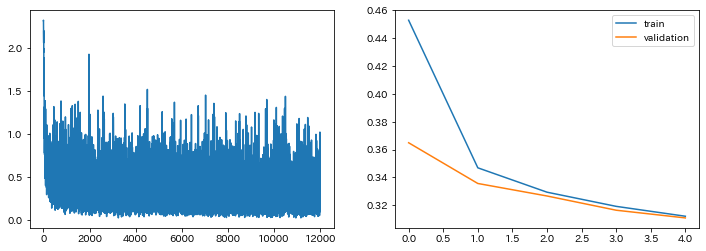

In [28]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].plot(cnn.loss_list)
ax[1].plot(cnn.loss_epoch_list, label='train')
ax[1].plot(cnn.loss_val_epoch_list, label='validation')
ax[1].legend()
plt.show()

## averagepoolingを使う

In [29]:
class cNN_averagepool:
    def __init__(self, epoch=5, verbose=True):
        self.epoch = epoch
        self.verbose = verbose
        self.layers = {}
        self.layers['Conv2d1'] = Conv2d(HeInitializer, AdaGrad, [1, 28, 28], [3, 1, 4, 4], stride=2, pad=2)
        self.layers['Activation1'] = Relu()
        self.layers['AveragePool2D1'] = AveragePool2D(2, 2, stride=1, pad=0)
        self.layers['Flatten1'] = Flatten()
        self.layers['Affine1'] =  FC(588, 10, XavierInitializer, AdaGrad)
        self.last_layer = SoftmaxWithLoss()

    def fit(self, X, y, X_val=None, y_val=None):
        self.loss_list = []
        self.loss_epoch_list = []
        self.loss_val_epoch_list = []
        for i in range(self.epoch):
            get_mini_batch = GetMiniBatch(X, y, batch_size=20, seed=i)
            loss_tmp_list = []
            for X_batch, y_batch in get_mini_batch:
                for layer in self.layers.values():
                    X_batch = layer.forward(X_batch)
                softmax = self.last_layer.forward(X_batch)
                loss, dA = self.last_layer.backward(y_batch)
                self.loss_list.append(loss)
                loss_tmp_list.append(loss)
                layers = list(self.layers.values())
                layers.reverse()
                for layer in layers:
                    dA = layer.backward(dA)
                    
            epoch_mean_loss = np.mean(loss_tmp_list)
            self.loss_epoch_list.append(epoch_mean_loss)
            if self.verbose:
                print(epoch_mean_loss)
            if X_val is not None and y_val is not None:
                X_val_copy = X_val.copy()
                for layer in self.layers.values():
                    X_val_copy = layer.forward(X_val_copy)
                softmax_val = self.last_layer.forward(X_val_copy)
                loss_val = -np.sum(y_val*np.log(softmax_val + 1e-7))/y_val.shape[0]
                self.loss_val_epoch_list.append(loss_val)
            
    def predict(self, X):
        for layer in self.layers.values():
            X = layer.forward(X)
        self.last_layer.forward(X)
        y_pred = np.argmax(self.last_layer.softmax, axis=1)
        
        return y_pred

In [30]:
cnn_average = cNN_averagepool()

In [31]:
cnn_average.fit(X_tr, y_tr, X_val, y_val)

0.42089763696577476
0.3375870024348415
0.32565121209987563
0.31900999945606934
0.314577582574958


In [32]:
y_pred_average = cnn_average.predict(X_val)
y_pred_average

array([6, 0, 8, ..., 0, 9, 4], dtype=int64)

In [33]:
y_val_label = np.argmax(y_val, axis=1)
y_val_label

array([6, 0, 8, ..., 0, 9, 4], dtype=int64)

In [34]:
accuracy = accuracy_score(y_val_label, y_pred_average)
print('accuracy_score:{}'.format(accuracy))

accuracy_score:0.9095


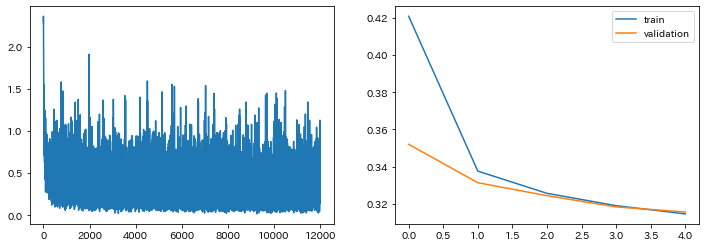

In [35]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].plot(cnn_average.loss_list)
ax[1].plot(cnn_average.loss_epoch_list, label='train')
ax[1].plot(cnn_average.loss_val_epoch_list, label='validation')
ax[1].legend()
plt.show()

# 【問題7】（アドバンス課題）LeNet

In [36]:
class LeNet:
    def __init__(self, epoch=5, verbose=True):
        self.epoch = epoch
        self.verbose = verbose
        self.layers = {}
        self.layers['Conv2d1'] = Conv2d(HeInitializer, AdaGrad, [1, 28, 28], [6, 1, 5, 5], stride=1, pad=0)
        self.layers['Activation1'] = Relu()
        self.layers['MaxPool2D1'] = MaxPool2D(2, 2, stride=1, pad=0)
        self.layers['Conv2d2'] = Conv2d(HeInitializer, AdaGrad, [6, 28, 28], [16, 6, 5, 5], stride=1, pad=0)
        self.layers['Activation2'] = Relu()
        self.layers['MaxPool2D2'] = MaxPool2D(2, 2, stride=1, pad=0)
        self.layers['Flatten1'] = Flatten()
        self.layers['Affine1'] =  FC(5184, 120, XavierInitializer, AdaGrad)
        self.layers['Activation3'] = Relu()
        self.layers['Affine2'] =  FC(120, 84, XavierInitializer, AdaGrad)
        self.layers['Activation4'] = Relu()
        self.layers['Affine3'] =  FC(84, 10, XavierInitializer, AdaGrad)
        self.last_layer = SoftmaxWithLoss()

    def fit(self, X, y, X_val=None, y_val=None):
        self.loss_list = []
        self.loss_epoch_list = []
        self.loss_val_epoch_list = []
        for i in range(self.epoch):
            get_mini_batch = GetMiniBatch(X, y, batch_size=20, seed=i)
            loss_tmp_list = []
            for X_batch, y_batch in get_mini_batch:
                for layer in self.layers.values():
                    X_batch = layer.forward(X_batch)
                softmax = self.last_layer.forward(X_batch)
                loss, dA = self.last_layer.backward(y_batch)
                self.loss_list.append(loss)
                loss_tmp_list.append(loss)
                layers = list(self.layers.values())
                layers.reverse()
                for layer in layers:
                    dA = layer.backward(dA)
                    
            epoch_mean_loss = np.mean(loss_tmp_list)
            self.loss_epoch_list.append(epoch_mean_loss)
            if self.verbose:
                print(epoch_mean_loss)
            if X_val is not None and y_val is not None:
                X_val_copy = X_val.copy()
                for layer in self.layers.values():
                    X_val_copy = layer.forward(X_val_copy)
                softmax_val = self.last_layer.forward(X_val_copy)
                loss_val = -np.sum(y_val*np.log(softmax_val + 1e-7))/y_val.shape[0]
                self.loss_val_epoch_list.append(loss_val)
            
    def predict(self, X):
        for layer in self.layers.values():
            X = layer.forward(X)
        self.last_layer.forward(X)
        y_pred = np.argmax(self.last_layer.softmax, axis=1)
        
        return y_pred

In [37]:
lenet = LeNet()

In [38]:
lenet.fit(X_tr, y_tr, X_val, y_val)

0.28710110424797214
0.1263251275628177
0.09963812704681428
0.08360601332255599
0.07475019777155781


In [49]:
y_pred_lenet = lenet.predict(X_val)
y_pred_lenet

array([6, 0, 8, ..., 0, 9, 4], dtype=int64)

In [43]:
y_val_label = np.argmax(y_val, axis=1)
y_val_label

array([6, 0, 8, ..., 0, 9, 4], dtype=int64)

In [50]:
accuracy = accuracy_score(y_val_label, y_pred_lenet)
print('accuracy_score:{}'.format(accuracy))

accuracy_score:0.9698333333333333


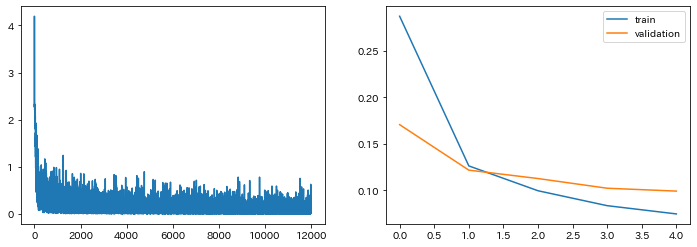

In [45]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].plot(lenet.loss_list)
ax[1].plot(lenet.loss_epoch_list, label='train')
ax[1].plot(lenet.loss_val_epoch_list, label='validation')
ax[1].legend()
plt.show()

# 【問題9】出力サイズとパラメータ数の計算

1.
入力サイズ : 144×144, 3チャンネル
フィルタサイズ : 3×3, 6チャンネル
ストライド : 1
パディング : なし
\
出力サイズ：142×142×6
パラメータ数：120,984
\
2.
入力サイズ : 60×60, 24チャンネル
フィルタサイズ : 3×3, 48チャンネル
ストライド　: 1
パディング : なし
\
出力サイズ：58×58×48
パラメータ数：161,472
\
3.
入力サイズ : 20×20, 10チャンネル
フィルタサイズ: 3×3, 20チャンネル
ストライド : 2
パディング : なし
\
出力サイズ：9×9×20
パラメータ数：1,620

# 【問題10】（アドバンス課題）フィルタサイズに関する調査

- 2×2などの偶数のものではなく、3×3等の奇数のフィルタが一般的に使われる理由
\
奇数サイズのフィルターサイズが使われるのは出力ピクセルを中心として入力ピクセルが対称的になるから。
- 高さや幅方向を持たない1×1のフィルタの効果:
\
DepthwiseConv2D等の出力チャンネル数を操作できないlayerの次の層として使い出力チャンネル数を増減させる。